In [ ]:
import matplotlib.pyplot as plt
import sys, os
sys.path.append('../')
result_dir = os.path.join(os.path.dirname(os.getcwd()), 'result', 'gnk')
figure_dir = os.path.join(os.path.dirname(os.getcwd()), 'figure')
from torch import nn, Tensor
from matplotlib.patches import Patch

import seaborn as sns

from src.simulator.gnk import gnk
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import entropy, norm
import matplotlib

plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

In [5]:
n = 500
eval_points = 2000
x_grid = np.linspace(-30, 30, eval_points)
exact_densities = np.load(os.path.join(result_dir, 'g_n_k_exact_densities_NLE.npy'))
theta = np.load(os.path.join(result_dir, 'g_n_k_theta_NLE.npy'))
t_x_grid = torch.tensor(x_grid, dtype = torch.float32)
t_theta = torch.tensor(theta, dtype = torch.float32)

In [7]:
mlmc_net_1 = torch.load(os.path.join(result_dir, 'gnk_nle_mlmc_n_10000_300.pt'), map_location=torch.device('cpu'))
mlmc_net_2 = torch.load(os.path.join(result_dir, 'gnk_nle_mlmc_n_10000_100.pt'), map_location=torch.device('cpu'))
mlmc_net_3 = torch.load(os.path.join(result_dir, 'gnk_nle_mlmc_n_10000_50.pt'), map_location=torch.device('cpu'))
mc_net_low = torch.load(os.path.join(result_dir, 'gnk_nle_mc_n_10000_low.pt'), map_location=torch.device('cpu'))
mc_net_high = torch.load(os.path.join(result_dir, 'gnk_nle_mc_n_300.pt'), map_location=torch.device('cpu'))

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_52107/2554240195.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlmc_net_1 = torch.load(os.path.join(result_d

In [8]:
def obtain_density_over_grid(network: nn.Module, x_grid: Tensor, theta: Tensor, network_type: str = 'nsf'):
    """
    network: nn.Module
    Input: x_grid [n_eval_points]
    theta: [theta_dim]
    """

    n_eval_points = x_grid.shape[0]
    theta = theta.repeat(n_eval_points, 1)    
    if network_type == 'nsf':
        x_grid = x_grid.view(-1, 1)
    
    return network.log_prob_unstandardized(x_grid, theta, log = False).detach().numpy()

def obtain_density(network: nn.Module, x_test: Tensor, theta_test: Tensor, network_type: str = 'nsf'):
    n = theta_test.shape[0]
    m = x_test.shape[0]
    density = np.zeros((n, m))

    for i in range(n):
        density[i:,] = obtain_density_over_grid(network, x_test, theta_test[i], network_type)

    return density

def obtain_kl(approximated_densities, exact_densities, forward = True):
    
    jitter = 1e-20
    exact_densities = np.clip(exact_densities, jitter, None)

    kl = np.zeros((approximated_densities.shape[0]))

    for i in range(approximated_densities.shape[0]):

        if forward:
            kl[i] = entropy(exact_densities[i], approximated_densities[i]) # forward KL divergence 

        else:
            kl[i] = entropy(approximated_densities[i], exact_densities[i])

    return kl

def integrated_squared_error(approximated_densities, exact_densities):
    """
    approximated_densities: [n, m]
    exact_densities: [n, m]
    """
    squared_error = np.sum((approximated_densities - exact_densities)**2, axis = 1)

    return squared_error

In [ ]:
dense_1 =  obtain_density(mlmc_net_1, t_x_grid, t_theta)
dense_2 = obtain_density(mlmc_net_2, t_x_grid, t_theta)
dense_3 = obtain_density(mlmc_net_3, t_x_grid, t_theta)
dense_low = obtain_density(mc_net_low, t_x_grid, t_theta)
dense_high = obtain_density(mc_net_high, t_x_grid, t_theta)

kl_1 = obtain_kl(dense_1, exact_densities)
kl_2 = obtain_kl(dense_2, exact_densities)
kl_3 = obtain_kl(dense_3, exact_densities)
kl_low = obtain_kl(dense_low, exact_densities)
kl_high = obtain_kl(dense_high, exact_densities)

In [10]:
ise_1 = integrated_squared_error(dense_1, exact_densities)
ise_2 = integrated_squared_error(dense_2, exact_densities)
ise_3 = integrated_squared_error(dense_3, exact_densities)
ise_low = integrated_squared_error(dense_low, exact_densities)
ise_high = integrated_squared_error(dense_high, exact_densities)

In [ ]:
def box_plot_gnk(metric_list:list, title:str):

    f, ax = plt.subplots(figsize = (3, 3))
    colors = ["#25A986", "#0C0C85", "#850D0C", "#850D0C", "#850D0C", "#850D0C", "#850D0C"]

    sns.boxplot(metric_list, ax = ax, palette = colors,#  orient='h',
                flierprops={'marker': '.', 'color': 'black', 'markersize': 5, 'markerfacecolor': 'black', 'markeredgecolor': 'black'})
    ax.set_ylabel(title, fontsize = 17)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(["$n = 10^4$", "$n = 300$", "$n_1 = 50$", "$n_1 = 100$", "$n_1 = 300$",
                        "MLMC ($500$)", "MLMC ($5000$)"], fontsize = 14, rotation = 90)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_yscale('log')

    for patch in ax.patches:
        patch.set_alpha(0.5)

    f.tight_layout()
    return f

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_52107/2403862254.py:6: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(metric_list, ax = ax, palette = colors,#  orient='h',
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_52107/2403862254.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$n = 10^4$", "$n = 300$", "$n_1 = 50$", "$n_1 = 100$", "$n_1 = 300$",


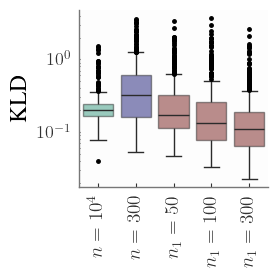

In [389]:
f = box_plot_gnk([kl_low, kl_high, kl_3, kl_2, kl_1], 'KLD')

In [390]:
f.savefig(os.path.join(figure_dir, 'gnk_kl_NLE.pdf'), bbox_inches='tight')

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_52107/2403862254.py:6: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(metric_list, ax = ax, palette = colors,#  orient='h',
/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_52107/2403862254.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$n = 10^4$", "$n = 300$", "$n_1 = 50$", "$n_1 = 100$", "$n_1 = 300$",


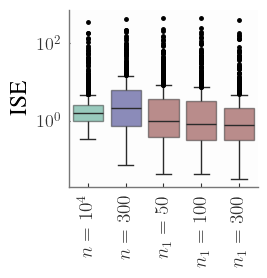

In [396]:
f = box_plot_gnk([ise_low, ise_high, ise_3, ise_2, ise_1], 'ISE')
f.savefig(os.path.join(figure_dir, 'gnk_ise_NLE.pdf'), bbox_inches='tight')

In [ ]:
def plot_exact_density_and_approximate_density(index: int, network_list: list[nn.Module], network_name: list[str], x_grid: Tensor, theta: Tensor, exact_density: Tensor,
                                               network_type_list: list[str], xlim = (-20, 20), add_legend = False): 
    
    colors = ["#850D0C", "#0C0C85", "#25A986"]
    fig, ax = plt.subplots(1, 1, figsize = (3., 3))
    ax.plot(x_grid, exact_density[index], color = "black", ls = "dashed", label = "(Almost) exact")
    for i in range(len(network_list)):
        approximated_density = obtain_density_over_grid(network_list[i], x_grid, theta[index], network_type = network_type_list[i])
        ax.plot(x_grid, approximated_density, label = network_name[i], color = colors[i])
        ax.fill_between(x_grid, approximated_density, alpha = 0.25, color = colors[i])

    if add_legend:
        fig.legend(fontsize = 12, frameon = False, loc='upper right', bbox_to_anchor=(1.0, 0.9))
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel("Density", fontsize = 17)
    ax.set_xlabel(r"$x$", fontsize = 17)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()

    return fig

/var/folders/r6/jlzvq0td5mqf05q5jm6fs2vm0000gp/T/ipykernel_52107/3197939188.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


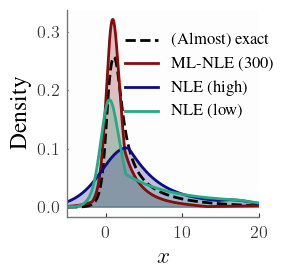

In [391]:
idx = 9
f = plot_exact_density_and_approximate_density(idx, [mlmc_net_1, mc_net_high, mc_net_low], ["ML-NLE (300)", "NLE (high)", "NLE (low)"], 
                                               t_x_grid, t_theta, exact_densities, network_type_list = ["nsf", "nsf", "nsf"],
                                               xlim = (-5, 20), add_legend=True)
f.show()
f.savefig(os.path.join(figure_dir, 'gnk_density_approximation_comparisoin_NLE.pdf'), bbox_inches = 'tight', dpi = 300)

In [ ]:
def plot_exact_density_and_approximate_density_multi(index_list: list, network_list: list[nn.Module], network_name: list[str], x_grid: Tensor, theta: Tensor, exact_density: Tensor,
                                               network_type_list: list[str], xlim = (-20, 20), add_legend = False): 
    
    colors = ["#850D0C", "#0C0C85", "#25A986"]
    fig, ax = plt.subplots(1, 4, figsize = (8, 2.3))
    ax = ax.flatten()

    shift = 30

    for index in index_list:
        ax[index].plot(x_grid, exact_density[index + shift], color = "black", ls = "dashed", label = "(Almost) exact")
        for i in range(len(network_list)):
            approximated_density = obtain_density_over_grid(network_list[i], x_grid, theta[index + shift], network_type = network_type_list[i])
            ax[index].plot(x_grid, approximated_density, label = network_name[i], color = colors[i])
            ax[index].fill_between(x_grid, approximated_density, alpha = 0.25, color = colors[i])

        if index == 3:
            ax[index].legend(fontsize = 10, frameon = False, loc='upper right', bbox_to_anchor=(1.5, 1.2))

        ax[index].set_xlim(xlim[0], xlim[1])
        ax[index].spines['top'].set_visible(False)
        ax[index].spines['right'].set_visible(False)
    fig.tight_layout()

    return fig

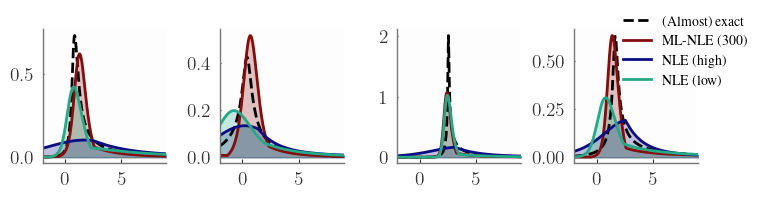

In [421]:
f = plot_exact_density_and_approximate_density_multi(list(range(4)), [mlmc_net_1, mc_net_high, mc_net_low], ["ML-NLE (300)", "NLE (high)", "NLE (low)"], t_x_grid, t_theta, exact_densities, network_type_list = ["nsf", "nsf", "nsf"],
                                               xlim = (-2, 9), add_legend=True)

In [422]:
f.savefig(os.path.join(figure_dir, 'gnk_4_density_mc.pdf'), bbox_inches = 'tight', dpi = 300)

In [ ]:
def plot_exact_density_and_approximate_density_multi_mlmc(index_list: list, network_list: list[nn.Module], network_name: list[str], x_grid: Tensor, theta: Tensor, exact_density: Tensor,
                                               network_type_list: list[str], xlim = (-20, 20), add_legend = False): 
    
    colors = ["#850D0C", "#850D0C", "#850D0C"]
    fig, ax = plt.subplots(1, 4, figsize = (8, 2.3))
    ax = ax.flatten()
    line_styles = ["solid", "dashed", "dotted"]

    shift = 30

    for index in index_list:
        ax[index].plot(x_grid, exact_density[index + shift], color = "black", ls = "dashed", label = "(Almost) exact")
        for i in range(len(network_list)):
            approximated_density = obtain_density_over_grid(network_list[i], x_grid, theta[index + shift], network_type = network_type_list[i])
            ax[index].plot(x_grid, approximated_density, label = network_name[i], color = colors[i],linestyle =  line_styles[i])

        if index == 3:
            ax[index].legend(fontsize = 10, frameon = False, loc='upper right', bbox_to_anchor=(1.5, 1.2))

        ax[index].set_xlim(xlim[0], xlim[1])
        ax[index].set_xlabel(r"$x$", fontsize = 17)
        ax[index].spines['top'].set_visible(False)
        ax[index].spines['right'].set_visible(False)
    fig.tight_layout()

    return fig

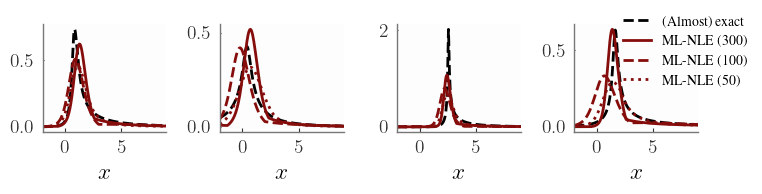

In [417]:
f = plot_exact_density_and_approximate_density_multi_mlmc(list(range(4)), [mlmc_net_1, mlmc_net_2, mlmc_net_3], ["ML-NLE (300)", "ML-NLE (100)", "ML-NLE (50)"], t_x_grid, t_theta, exact_densities, network_type_list = ["nsf", "nsf", "nsf"],
                                               xlim =  (-2, 9), add_legend=True)

In [411]:
f.savefig(os.path.join(figure_dir, 'gnk_4_density_mlmc.pdf'), bbox_inches = 'tight', dpi = 300)

In [ ]:
n = 1; m = 1000
theta_star = theta[9]

simulator = gnk(very_low = False)
noise = simulator.noise_generator(n = n, m = m) 
x_low = simulator.low_simulator(theta = theta_star, noise = noise)
x_high = simulator.high_simulator(theta = theta_star, noise = noise)

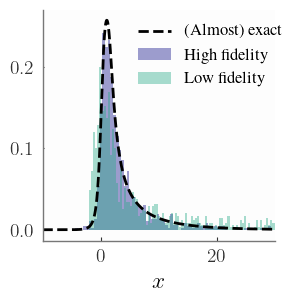

In [423]:
fig, ax = plt.subplots(1, 1, figsize = (3., 3))
colors = ["#850D0C", "#0C0C85", "#25A986"]
ax.plot(x_grid, exact_densities[9], color = "black", ls = "dashed", label = "(Almost) exact")
ax.hist(x_high[0], bins = 100, density = True, alpha = 0.4, color = "#0C0C85", label = "High fidelity")
ax.hist(x_low[0], bins = 100, density = True, alpha = 0.4, color = "#25A986", label = "Low fidelity")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-10, 30)
ax.set_xlabel(r"$x$", fontsize = 17)
ax.legend(frameon = False, fontsize = 12, loc='upper right', bbox_to_anchor=(1.1, 1.0))

In [424]:
fig.savefig(figure_dir + '/gnk_density_low_high_fidelity.pdf', bbox_inches = 'tight', dpi = 300)